#Построение модели для прогнозирования суммы покупки клиента.

### Постановки задачи

Розничная компания хочет понять покупательское поведение клиентов (в частности, сумму покупки) в отношении различных продуктов разных категорий. Они поделились сводкой о покупках различных клиентов для выбранных крупносерийных продуктов за последний месяц. Набор данных также содержит демографические данные клиентов (возраст, пол, семейное положение, город проживания, как долго покупатель живет в этом городе), сведения о продукте (product_id и категория продукта) и общую сумму покупки за последний месяц.

Теперь они хотят построить модель для прогнозирования суммы покупки клиента по различным продуктам, которая поможет им создать персонализированное предложение для клиентов по различным продуктам.

Определение переменной

Подключение библиотек и скриптов

In [46]:
import numpy as np
import pandas as pd
import random
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
matplotlib.rcParams.update({'font.size': 14})

In [ ]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [139]:
from google.colab import drive
drive.mount('/gdrive')
with open('/gdrive/MyDrive/Black_Friday_Sales/data/train.csv', 'r') as f:
        TRAIN_DATASET_PATH = pd.read_csv(f)
with open('/gdrive/MyDrive/Black_Friday_Sales/data/test.csv', 'r') as f:
        TEST_DATASET_PATH = pd.read_csv(f)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### Загрузка данных <a class='anchor' id='load'>

**Описание датасета**

* **User_ID** - идентификационный номер покупателя
* **Product_ID** - идентификационный номер товара
* **Gender** - пол покупателя
* **Age** - возраст покупателя
* **Occupation** - род деятельности покупателя
* **City_Category** - город проживания
* **Stay_In_Current_City_Years** - как долго покупатель живет в этом городе
* **Marital_Status** - семейное положение покупателя
* **Product_Category_1** - категория товара 1
* **Product_Category_2** - категория товара 2
* **Product_Category_3** - категория товара 3
* **Purchase** - сумма покупок

In [140]:
train_df = TRAIN_DATASET_PATH
train_df.tail()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
79995,1000919,P00217942,F,36-45,1,C,1,0,5,NaN,NaN,5231
79996,1001733,P00255742,M,18-25,14,B,0,1,3,4.0,NaN,10904
79997,1002674,P00209842,M,26-35,4,A,1,0,5,8.0,NaN,6953
79998,1005599,P00171842,M,36-45,7,A,1,0,8,14.0,NaN,5888
79999,1002121,P00244642,M,55+,13,C,0,1,11,NaN,NaN,3054


In [141]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User_ID                     80000 non-null  int64  
 1   Product_ID                  80000 non-null  object 
 2   Gender                      80000 non-null  object 
 3   Age                         80000 non-null  object 
 4   Occupation                  80000 non-null  int64  
 5   City_Category               80000 non-null  object 
 6   Stay_In_Current_City_Years  80000 non-null  object 
 7   Marital_Status              80000 non-null  int64  
 8   Product_Category_1          80000 non-null  int64  
 9   Product_Category_2          54892 non-null  float64
 10  Product_Category_3          24331 non-null  float64
 11  Purchase                    80000 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 7.3+ MB


In [142]:
test_df = TEST_DATASET_PATH
test_df.tail()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
19995,1002020,P00289842,M,26-35,7,B,0,1,1,16.0,NaN
19996,1005722,P00110942,M,26-35,20,A,2,1,1,2.0,NaN
19997,1004028,P00177942,M,26-35,4,A,2,0,5,8.0,NaN
19998,1000010,P00178242,F,36-45,1,B,4+,1,8,NaN,NaN
19999,1005737,P00283342,M,46-50,15,C,2,0,5,14.0,NaN


In [143]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 80000
Строк в тесте 20000


In [144]:
train_df.shape[1] - 1 == test_df.shape[1]

True

### Приведение типов

In [145]:
train_df.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

In [146]:
train_df['User_ID'] = train_df['User_ID'].astype(str)
train_df['Product_ID'] = train_df['Product_ID'].astype(str)

## 1. EDA  <a class='anchor' id='eda'>
Делаем EDA для:
- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

**Целевая переменная**

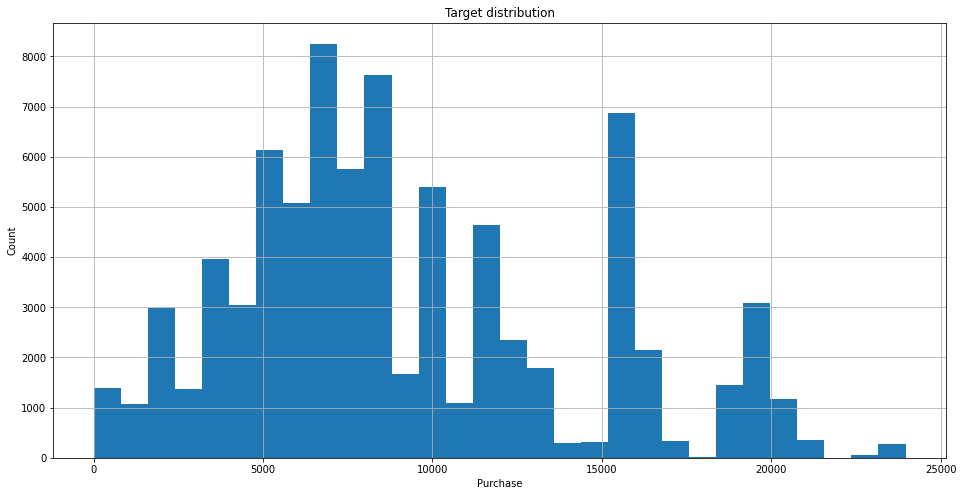

In [147]:
plt.figure(figsize = (16, 8))

train_df['Purchase'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Purchase')

plt.title('Target distribution')
plt.show()

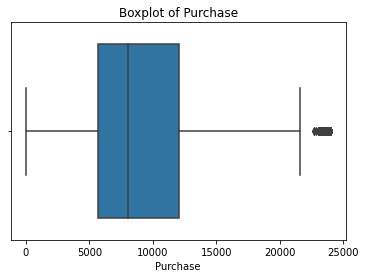

In [148]:
sns.boxplot(train_df["Purchase"])
plt.title("Boxplot of Purchase")
plt.show()

In [149]:
train_df["Purchase"].skew()

0.6036877743828393

In [150]:
train_df["Purchase"].kurtosis()

-0.3359215454948319

**Качественные переменные**

In [151]:
train_df.describe()

,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,80000.000000,80000.000000,80000.000000,54892.000000,24331.000000,80000.000000
mean,8.086863,0.409388,5.388463,9.851873,12.676421,9243.933162
std,6.536459,0.491724,3.922793,5.079163,4.109343,5021.298356
min,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,2.000000,0.000000,1.000000,5.000000,9.000000,5679.750000
50%,7.000000,0.000000,5.000000,9.000000,14.000000,8039.000000
75%,14.000000,1.000000,8.000000,15.000000,16.000000,12046.000000
max,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d23f10370>,
      dtype=object)

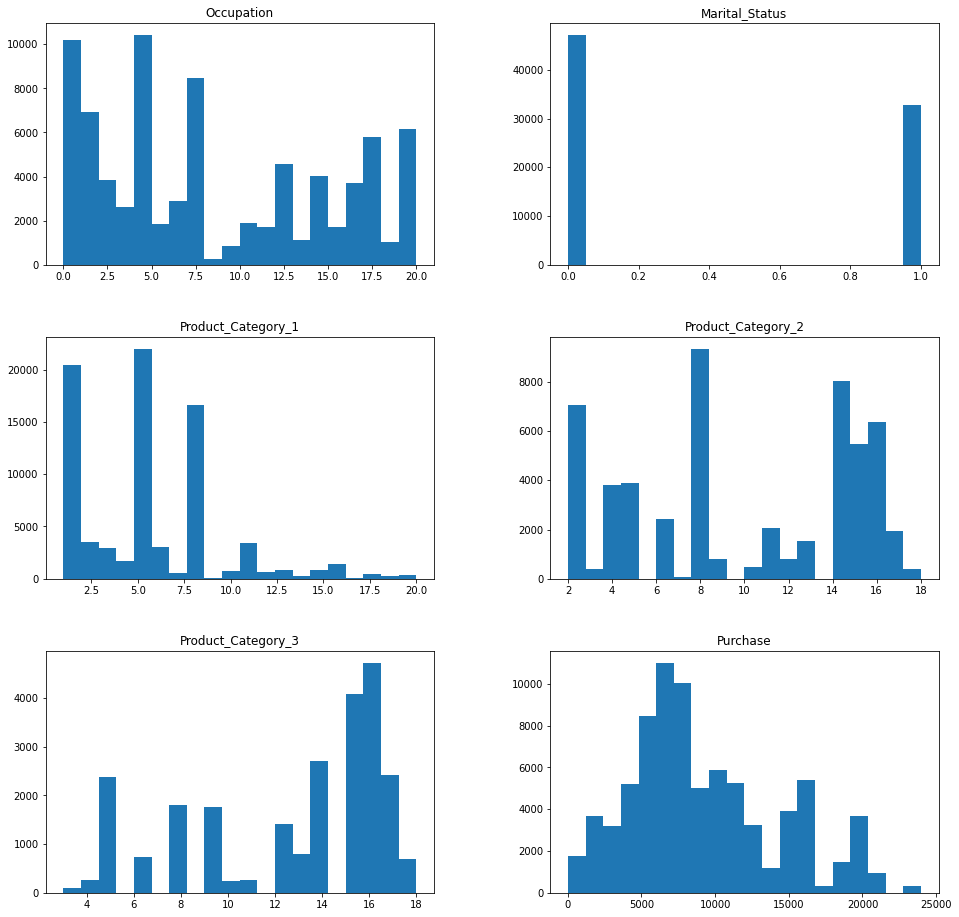

In [152]:
train_df.hist(figsize=(16,16), bins=20, grid=False)

**Номинативные переменные**

In [153]:
train_df.select_dtypes(include='object').columns.tolist()

['User_ID',
 'Product_ID',
 'Gender',
 'Age',
 'City_Category',
 'Stay_In_Current_City_Years']

In [154]:
train_df['Gender'].value_counts()

M    60068
F    19932
Name: Gender, dtype: int64

In [155]:
train_df['Age'].value_counts()

26-35    32067
36-45    16025
18-25    14286
46-50     6777
51-55     5555
55+       3110
0-17      2180
Name: Age, dtype: int64

In [156]:
train_df['City_Category'].value_counts()

B    33767
C    24778
A    21455
Name: City_Category, dtype: int64

In [157]:
train_df['Stay_In_Current_City_Years'].value_counts()

1     28287
2     14830
3     13853
4+    12250
0     10780
Name: Stay_In_Current_City_Years, dtype: int64

### 2. Обработка выбросов  <a class='anchor' id='outlier'>
Что можно делать с ними?
1. Выкинуть эти данные (только на трейне, на тесте ничего не выкидываем)
2. Заменять выбросы разными методами (медианы, средние значения, np.clip и т.д.)
3. Делать/не делать дополнительную фичу
4. Ничего не делать

In [158]:
train_df['Gender'].value_counts()

M    60068
F    19932
Name: Gender, dtype: int64

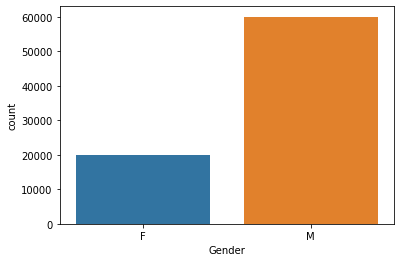

In [159]:
sns.countplot(train_df['Gender'])
plt.show()